# MSRP Predictor - XGBoost Regression

#### Dataset Source:  https://www.kaggle.com/CooperUnion/cardataset

This is the XGBoost version of the MSRP Predictor. Unfortunately, this version did not perform anywhere near as well as the Keras version.

#### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score, mean_absolute_error

import xgboost as xgb
from xgboost import XGBRegressor, plot_tree

/Users/briandunn/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Versions of Relevant Libraries

In [2]:
print("Pandas:".ljust(10, ' '), pd.__version__)
print("NumPy:".ljust(10, ' '), np.__version__)
print("Seaborn:".ljust(10, ' '), sns.__version__)
print("XGBoost:".ljust(10, ' '), xgb.__version__)

Pandas:    1.4.2
NumPy:     1.21.5
Seaborn:   0.11.2
XGBoost:   1.5.0


#### Ingest Dataset, Drop Unnecessary Features, & Rename Other Features (as Necessary)

In [3]:
data = pd.read_csv('Car Features and MSRP/data.csv')

data.drop(columns=['Market Category', 'Model'], inplace=True)

data.rename(columns={'Engine Fuel Type' : 'fuel_type', 
                     'Engine HP' : 'hp', 
                     'Engine Cylinders' : 'cylinders', 
                     'Transmission Type' : 'transmission', 
                     'Number of Doors' : '# of Doors', 
                     'MSRP' : 'target'}, inplace=True)

data['Year'] = data['Year'].astype(str)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11812 entries, 0 to 11913
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Make           11812 non-null  object 
 1   Year           11812 non-null  object 
 2   fuel_type      11812 non-null  object 
 3   hp             11812 non-null  float64
 4   cylinders      11812 non-null  float64
 5   transmission   11812 non-null  object 
 6   Driven_Wheels  11812 non-null  object 
 7   # of Doors     11812 non-null  float64
 8   Vehicle Size   11812 non-null  object 
 9   Vehicle Style  11812 non-null  object 
 10  highway MPG    11812 non-null  int64  
 11  city mpg       11812 non-null  int64  
 12  Popularity     11812 non-null  int64  
 13  target         11812 non-null  int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 1.4+ MB


#### More Information about Dataset

In [4]:
data.describe()

,hp,cylinders,# of Doors,highway MPG,city mpg,Popularity,target
count,11812.000000,11812.000000,11812.000000,11812.000000,11812.000000,11812.000000,1.181200e+04
mean,249.504487,5.649424,3.432526,26.320945,19.328141,1553.679902,4.055994e+04
std,109.206947,1.751646,0.882919,7.443589,6.527734,1440.067820,6.028413e+04
min,55.000000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,170.000000,4.000000,2.000000,22.000000,16.000000,549.000000,2.099000e+04
50%,227.000000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.997000e+04
75%,300.000000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.220500e+04
max,1001.000000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


#### Numerical vs Categorical Features

In [5]:
print('Numerical Features')

numerical_features = ['hp', 'cylinders', '# of Doors', 'highway MPG', 'city mpg', 'Popularity']

for x in numerical_features:
    print(x.ljust(18, ' '), len(data[x].unique()))

print('\n----------------------\n')

print('Categorical Features')

categorical_features = ['Year', 'Make', 'fuel_type', 'transmission', 'Driven_Wheels', 'Vehicle Size', 'Vehicle Style']

for x in categorical_features:
    print(x.ljust(18, ' '), len(data[x].unique()))


Numerical Features
hp                 355
cylinders          9
# of Doors         3
highway MPG        44
city mpg           50
Popularity         47

----------------------

Categorical Features
Year               28
Make               47
fuel_type          9
transmission       5
Driven_Wheels      4
Vehicle Size       3
Vehicle Style      16


#### List of Different Autombile Brands

In [6]:
print(sorted(data['Make'].unique()))

['Acura', 'Alfa Romeo', 'Aston Martin', 'Audi', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Dodge', 'FIAT', 'Ferrari', 'Ford', 'GMC', 'Genesis', 'HUMMER', 'Honda', 'Hyundai', 'Infiniti', 'Kia', 'Lamborghini', 'Land Rover', 'Lexus', 'Lincoln', 'Lotus', 'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz', 'Mitsubishi', 'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Rolls-Royce', 'Saab', 'Scion', 'Spyker', 'Subaru', 'Suzuki', 'Toyota', 'Volkswagen', 'Volvo']


#### Count of Each Transmission Type

In [7]:
data['transmission'].value_counts()

AUTOMATIC           8231
MANUAL              2922
AUTOMATED_MANUAL     625
UNKNOWN               19
DIRECT_DRIVE          15
Name: transmission, dtype: int64

#### Remove Outliers

In [8]:
cols_to_check = ['hp', 'cylinders', '# of Doors', 'highway MPG','city mpg', 'Popularity', 'target']

# Remove outliers using the 'IQR * 1.5' rule
def remove_outliers(df, feature):
    q1, q3 = np.percentile(df[feature], [25,75])
    iqr = q3-q1
    ul = q3 + (iqr * 1.5)
    ll = q1 - (iqr * 1.5)
    neo_data = df[(df[feature].values > ll) & (df[feature].values < ul)]
    return neo_data


for x in cols_to_check:
    data = remove_outliers(data, x)


#### Display Correlation Matrix

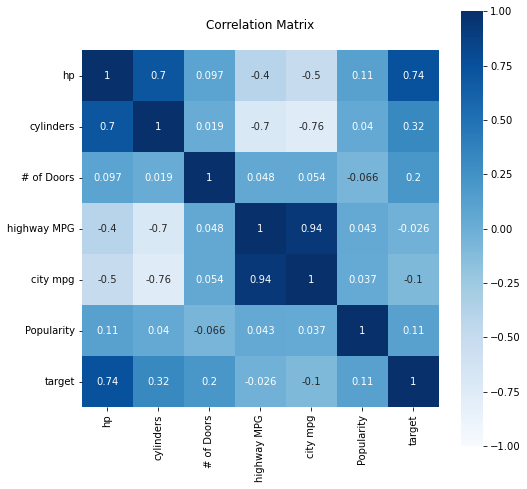

In [9]:
plt.figure(figsize=(8, 8))
plt.title('Correlation Matrix\n')
sns.heatmap(data.corr(), 
            annot=True, 
            xticklabels=True, 
            yticklabels=True, 
            square=True,
            vmin=-1.0, 
            vmax=1.0, 
            cmap="Blues")

plt.show()

#### Make Dataset Sparse

In [10]:
for x in categorical_features:
    sparse_data = pd.DataFrame(pd.get_dummies(data[x]))
    data = data.join(sparse_data)
    
# Remove the unnecessary features
data.drop(columns=categorical_features, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9539 entries, 0 to 11913
Columns: 107 entries, hp to Wagon
dtypes: float64(3), int64(4), uint8(100)
memory usage: 1.7 MB


#### Split Dataset into Training & Testing Dataset as Well as Features & Labels

In [11]:
y = data.loc[:, 'target']
X = data.loc[:, data.columns != 'target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7631, 106)
(7631,)
(1908, 106)
(1908,)


#### Define Parameters & XGBRegressor

In [12]:
param = {"booster":"dart", "objective":"reg:squarederror"}

model = XGBRegressor(**param,
                     learning_rate=0.135,
                     n_estimators=250,
                     reg_alpha=0.25, 
                     reg_lambda=0.25,
                     random_state=42,
                     verbosity=1, 
                     tree_method='approx',
                     eval_metric='mae')

#### Fit Model to Training Dataset

In [ ]:
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

[0]	validation_0-mae:25027.89258
[1]	validation_0-mae:21829.16406


/Users/briandunn/opt/anaconda3/envs/tensor/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-mae:19078.15039
[3]	validation_0-mae:16725.71875
[4]	validation_0-mae:14738.88086
[5]	validation_0-mae:13006.06738
[6]	validation_0-mae:11459.80664
[7]	validation_0-mae:10191.54004
[8]	validation_0-mae:9023.04590
[9]	validation_0-mae:8028.26318
[10]	validation_0-mae:7219.56641
[11]	validation_0-mae:6559.84375
[12]	validation_0-mae:5990.25732
[13]	validation_0-mae:5494.96631
[14]	validation_0-mae:5109.40674
[15]	validation_0-mae:4816.58252
[16]	validation_0-mae:4565.81689
[17]	validation_0-mae:4366.94043
[18]	validation_0-mae:4211.54785
[19]	validation_0-mae:4076.45679
[20]	validation_0-mae:3953.95142
[21]	validation_0-mae:3867.42847
[22]	validation_0-mae:3788.29932
[23]	validation_0-mae:3723.96069
[24]	validation_0-mae:3671.53345
[25]	validation_0-mae:3622.03345
[26]	validation_0-mae:3581.37817
[27]	validation_0-mae:3548.38428
[28]	validation_0-mae:3507.80518
[29]	validation_0-mae:3465.31421
[30]	validation_0-mae:3446.18994
[31]	validation_0-mae:3417.23315
[32]	validat

#### Make Predictions

In [ ]:
y_pred = model.predict(X_test)
preds = [round(value) for value in y_pred]

#### Evaluate Results

In [ ]:
rmse = round(MSE(y_test, preds, squared=False),2)
mse = round(MSE(y_test, preds, squared=True),2)
mae = round(mean_absolute_error(y_test, preds),2)

print("RMSE:".rjust(10, ' '), str(rmse).rjust(12))
print('MSE:'.rjust(10, ' '), str(mse).rjust(12))
print("MAE:".rjust(10, ' '), str(mae).rjust(12))

#### Visualize: Feature Importances'

In [ ]:
plt.figure(figsize=(15,20))
plt.title("Feature Importances'")
plt.xlabel("Feature Importances'")
plt.ylabel('Features')
plt.barh(X_test.columns[0:59], model.feature_importances_[0:59], height=0.75, color='green')
plt.show()

In [ ]:
plt.figure(figsize=(15,20))
plt.title("Feature Importances'")
plt.xlabel("Feature Importances'")
plt.ylabel('Features')
plt.barh(X_test.columns[60:], model.feature_importances_[60:], height=0.50, color='green')
plt.show()

#### Save Model

In [ ]:
model.save_model('MSRP Predictor-XGBoost Regression.json')